In [122]:
import pandas as pd
df = pd.read_csv('AZ_cleaned.csv') #, index_col = 0) this line removes the index column but messes with other columns, see change log
df #print(df.head(10)) for the time being, we can have it just as 'df' but I don't think that works in normal jupyter notebook?

c:\Users\School\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,16,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration,road_number,milepost,consent_search,vehicle_type,ethnicity
0,AZ-2009-001,AZ,2009-01-06,NaN,NaN,Maricopa County,4013.0,I10 165 NA,NaN,M,...,False,Warning,False,5283,NaN,I10,165.0,False,12PU 2007,H
1,AZ-2009-002,AZ,2009-01-18,NaN,NaN,Maricopa County,4013.0,US60 185 NA,NaN,M,...,False,Warning,False,5283,NaN,US60,185.0,False,4DSD 2004,W
2,AZ-2009-003,AZ,2009-01-20,NaN,NaN,Maricopa County,4013.0,SR202 16 NA,NaN,M,...,False,Warning,False,5283,NaN,SR202,16.0,False,4DSD 2001,H
3,AZ-2009-004,AZ,2009-01-24,NaN,NaN,Maricopa County,4013.0,US60 172.4 NA,NaN,F,...,False,Citation,False,5283,NaN,US60,172.4,False,4DSD 2003,H
4,AZ-2009-005,AZ,2009-01-25,NaN,NaN,Maricopa County,4013.0,US60 181 NA,NaN,F,...,False,Warning,False,5283,NaN,US60,181.0,False,4DSD 2001,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251987,AZ-2015-450515,AZ,2015-11-30,23:48,7.0,Maricopa County,4013.0,I17 202 NA,NaN,M,...,False,Warning,False,7460,0-10,I17,202.0,False,CP 1994,H
2251988,AZ-2015-450516,AZ,2015-11-30,23:50,3.0,Coconino County,4005.0,US89 434 NA,NaN,F,...,False,Citation,False,7829,NaN,US89,434.0,False,12PU 2005,N
2251989,AZ-2015-450517,AZ,2015-11-30,23:53,7.0,Maricopa County,4013.0,I17 202.9 NA,NaN,M,...,False,Warning,False,7460,NaN,I17,202.9,False,4DSD 2015,B
2251990,AZ-2015-450518,AZ,2015-11-30,23:56,7.0,Maricopa County,4013.0,NA NA 7THAVE/JEFFERSON,NaN,M,...,False,Citation,False,7833,NaN,NaN,NaN,False,34PU 2006,H


In [123]:
df = df[(df['stop_date'] >= '2014') & (df['stop_date'] < '2016')] #limiting to only dates in 2014 and 2015

    IDENTIFYING COLUMN NAMES

In [124]:
column_names = []
for col in df:
    column_names.append(col)

print(column_names)

['id', 'state', 'stop_date', 'stop_time', 'location_raw', 'county_name', 'county_fips', 'fine_grained_location', 'police_department', 'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw', 'driver_race', 'violation_raw', 'violation', 'search_conducted', 'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome', 'is_arrested', 'officer_id', 'stop_duration', 'road_number', 'milepost', 'consent_search', 'vehicle_type', 'ethnicity']


    REMOVING ALL ROWS WHICH DO NOT CONTAIN VALUES IN THE 'STOP OUTCOME' OR 'DRIVER RACE' COLUMNS

In [125]:
#removing any columns missing values, or having NaN in the 'stop_outcome' column
df.dropna(how = 'any', subset = ['stop_outcome', 'driver_race'], axis = 0, inplace = True)
df 

<ipython-input-125-18a099a0b1f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(how = 'any', subset = ['stop_outcome', 'driver_race'], axis = 0, inplace = True)


,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration,road_number,milepost,consent_search,vehicle_type,ethnicity
1293055,AZ-2014-000001,AZ,2014-01-01,00:01,NaN,NaN,NaN,SR73 357 NA,NaN,F,...,False,Citation,False,7287,11-20,SR73,357.0,False,4DSD 2006,N
1293056,AZ-2014-000002,AZ,2014-01-01,00:02,NaN,Pima County,4019.0,I10 255 NA,NaN,M,...,False,Warning,False,7288,0-10,I10,255.0,False,12PU 2000,W
1293057,AZ-2014-000003,AZ,2014-01-01,00:03,NaN,NaN,NaN,NA NA 2501 W HWY 66 WINSLOW AZ,NaN,F,...,False,Arrest,True,6600,11-20,NaN,NaN,False,2DSD 2005,N
1293058,AZ-2014-000004,AZ,2014-01-01,00:04,NaN,Maricopa County,4013.0,SR101 20 NA,NaN,M,...,False,Warning,False,5937,21-30,SR101,20.0,False,4DSD 1997,H
1293059,AZ-2014-000005,AZ,2014-01-01,00:05,NaN,Maricopa County,4013.0,SR51 13.6 NA,NaN,F,...,False,Warning,False,4492,11-20,SR51,13.6,False,NA NA,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251987,AZ-2015-450515,AZ,2015-11-30,23:48,7.0,Maricopa County,4013.0,I17 202 NA,NaN,M,...,False,Warning,False,7460,0-10,I17,202.0,False,CP 1994,H
2251988,AZ-2015-450516,AZ,2015-11-30,23:50,3.0,Coconino County,4005.0,US89 434 NA,NaN,F,...,False,Citation,False,7829,NaN,US89,434.0,False,12PU 2005,N
2251989,AZ-2015-450517,AZ,2015-11-30,23:53,7.0,Maricopa County,4013.0,I17 202.9 NA,NaN,M,...,False,Warning,False,7460,NaN,I17,202.9,False,4DSD 2015,B
2251990,AZ-2015-450518,AZ,2015-11-30,23:56,7.0,Maricopa County,4013.0,NA NA 7THAVE/JEFFERSON,NaN,M,...,False,Citation,False,7833,NaN,NaN,NaN,False,34PU 2006,H


    REMOVING ALL ROWS WHICH EITHER DO NOT CONTAIN ANY VALUES AT ALL, OR ARE THE RAW VERSIONS OF OTHER COLUMNS

In [126]:
def remove_redundancies(df_name):
    redundant_columns = ['id','state', 'stop_date', 'location_raw', 'county_name', 'county_fips', 'fine_grained_location', 
    'driver_age_raw', 'driver_race_raw', 'violation_raw', 'search_type_raw', 'officer_id', 'stop_duration', 'road_number',
    'milepost','vehicle_type', 'police_department', 'stop_time', 'driver_age', 'ethnicity'] #note: stop time is temporarily removed because the current code doesnt want to read it properly
    df_name = df.drop(columns = redundant_columns, axis = 1, inplace = True)   #note 2: driver_age can be included if values are present in your dataset
    return df_name

remove_redundancies(df)


c:\Users\School\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [127]:
df

,driver_gender,driver_race,violation,search_conducted,search_type,contraband_found,stop_outcome,is_arrested,consent_search
1293055,F,Other,Speeding,False,NaN,False,Citation,False,False
1293056,M,White,NaN,False,NaN,False,Warning,False,False
1293057,F,Other,"DUI,Paperwork",False,NaN,False,Arrest,True,False
1293058,M,Hispanic,NaN,False,NaN,False,Warning,False,False
1293059,F,White,NaN,False,NaN,False,Warning,False,False
...,...,...,...,...,...,...,...,...,...
2251987,M,Hispanic,NaN,False,NaN,False,Warning,False,False
2251988,F,Other,NaN,False,NaN,False,Citation,False,False
2251989,M,Black,NaN,False,NaN,False,Warning,False,False
2251990,M,Hispanic,NaN,False,NaN,False,Citation,False,False


In [128]:
print(df.isnull().sum())
df.dropna(subset=["violation"], inplace=True)
print('\n')
print(df.isnull().sum())

driver_gender            0
driver_race              0
violation           663236
search_conducted         0
search_type         953721
contraband_found         0
stop_outcome             0
is_arrested              0
consent_search       39169
dtype: int64


driver_gender            0
driver_race              0
violation                0
search_conducted         0
search_type         294741
contraband_found         0
stop_outcome             0
is_arrested              0
consent_search       24666
dtype: int64


<ipython-input-128-b7772e53fb36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["violation"], inplace=True)


    BECAUSE WE SUSPECT A CORRELATION BEWTEEN DRIVER RACE, AND STOP OUTCOME, PLOTTING THE DRIVER RACE DISTRIBUTION TO SEE IF IT IS SKEWED TOWARDS CERTAIN GROUP

In [129]:
print(df.value_counts(df['driver_race']))

driver_race
White       167966
Hispanic     78367
Other        22927
Black        18631
Asian         7757
dtype: int64


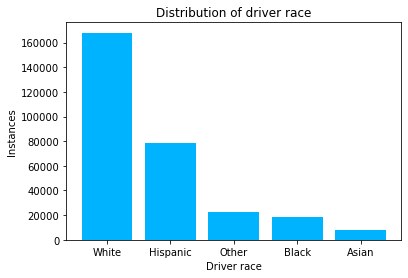

In [130]:
import numpy as np
import matplotlib.pyplot as plt
 
height = df.value_counts(df['driver_race']) #counting instances of each 'class' of driver race
bars = ('White','Hispanic','Other','Black','Asian') #labelling the abrs
x_pos = np.arange(len(bars))
 
plt.bar(x_pos, height, color = (0,0.7,1,1)) #plotting and selecting colour

plt.title('Distribution of driver race')
plt.xlabel('Driver race')
plt.ylabel('Instances')
 
plt.xticks(x_pos, bars)  #Create names on the x axis
 
plt.show()

In [131]:
df

,driver_gender,driver_race,violation,search_conducted,search_type,contraband_found,stop_outcome,is_arrested,consent_search
1293055,F,Other,Speeding,False,NaN,False,Citation,False,False
1293057,F,Other,"DUI,Paperwork",False,NaN,False,Arrest,True,False
1293060,F,White,Registration/plates,False,NaN,False,Citation,False,False
1293061,M,Hispanic,Other,True,NaN,False,Arrest,True,NaN
1293064,M,White,Other,True,NaN,True,Arrest,True,NaN
...,...,...,...,...,...,...,...,...,...
2224693,M,White,"Other,Paperwork",False,NaN,False,Citation,False,False
2224718,F,White,Moving violation,False,NaN,False,Citation,False,False
2227501,M,Hispanic,License,True,NaN,False,Citation,False,NaN
2228756,M,Hispanic,Other,True,NaN,False,Arrest,True,NaN


In [132]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['stop_outcome'], axis = 1)
y = df['stop_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

Xd = pd.get_dummies(X, columns = ['driver_gender', 'driver_race','violation', 'search_conducted', 'search_type', 
                                  'contraband_found', 'is_arrested', 'consent_search'])

X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state = 0)
print(Xd.shape[1] - X.shape[1], 'columns added')

400 columns added


    CREATING TESTING DATAFRAME USING FIRST 100000 VALUES TO DECREASE PROCESSING TIME WHILE TESTING CODE AND PARAMETERS

In [133]:
""" df_testing = df.head(100000) #creating copy of dataframe that contains the first 100000 values for testing of code

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings

X = df_testing.drop(['stop_outcome'], axis = 1) 
y = df_testing['stop_outcome']

Xd = pd.get_dummies(X, columns = ['driver_gender', 'driver_race','violation', 'search_conducted', 'search_type', 
                                  'contraband_found', 'is_arrested', 'consent_search']) #creating dummy values for all columns containing non-numerical values

X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state = 0)
print(Xd.shape[1] - X.shape[1], 'columns added') """

" df_testing = df.head(100000) #creating copy of dataframe that contains the first 100000 values for testing of code\n\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestClassifier\nimport warnings\n\nX = df_testing.drop(['stop_outcome'], axis = 1) \ny = df_testing['stop_outcome']\n\nXd = pd.get_dummies(X, columns = ['driver_gender', 'driver_race','violation', 'search_conducted', 'search_type', \n                                  'contraband_found', 'is_arrested', 'consent_search']) #creating dummy values for all columns containing non-numerical values\n\nX_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state = 0)\nprint(Xd.shape[1] - X.shape[1], 'columns added') "

In [134]:
Xd.dropna(axis = 0, inplace = True) #removing all rows which do not contain any values
Xd

,driver_gender_F,driver_gender_M,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White,violation_DUI,"violation_DUI,Equipment","violation_DUI,Equipment,License",...,violation_Stop sign/light,search_conducted_False,search_conducted_True,search_type_Consent,contraband_found_False,contraband_found_True,is_arrested_False,is_arrested_True,consent_search_False,consent_search_True
1293055,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1293057,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,1,0
1293060,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1293061,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
1293064,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224693,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
2224718,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
2227501,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
2228756,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0


In [136]:
Xd['violation_DUI,Equipment', 'violation_DUI,Equipment,License', 'violation_DUI,Equipment,License,Moving violation,Other', 'violation_DUI,Equipment,License,Moving violation,Other,Registration/plates,Safe movement,Speeding,Stop sign/light', 'violation_DUI,Equipment,License,Other', 'violation_DUI,Equipment,License,Other,Paperwork', 'violation_DUI,Equipment,License,Other,Paperwork,Registration/plates,Speeding', 'violation_DUI,Equipment,License,Other,Speeding', 'violation_DUI,Equipment,License,Paperwork', 'violation_DUI,Equipment,License,Registration/plates', 'violation_DUI,Equipment,Moving violation', 'violation_DUI,Equipment,Moving violation,Other', 'violation_DUI,Equipment,Other', 'violation_DUI,Equipment,Other,Paperwork', 'violation_DUI,Equipment,Paperwork', 'violation_DUI,Equipment,Paperwork,Speeding', 'violation_DUI,Equipment,Speeding', 'violation_DUI,License', 'violation_DUI,License,Moving violation', 'violation_DUI,License,Moving violation,Other', 'violation_DUI,License,Moving violation,Other,Paperwork', 'violation_DUI,License,Moving violation,Other,Paperwork,Registration/plates', 'violation_DUI,License,Moving violation,Other,Paperwork,Speeding', 'violation_DUI,License,Moving violation,Other,Safe movement,Speeding', 'violation_DUI,License,Moving violation,Other,Safe movement,Speeding,Stop sign/light', 'violation_DUI,License,Moving violation,Other,Speeding', 'violation_DUI,License,Moving violation,Other,Stop sign/light', 'violation_DUI,License,Moving violation,Paperwork', 'violation_DUI,License,Moving violation,Safe movement', 'violation_DUI,License,Moving violation,Safe movement,Speeding', 'violation_DUI,License,Moving violation,Speeding', 'violation_DUI,License,Other', 'violation_DUI,License,Other,Paperwork', 'violation_DUI,License,Other,Paperwork,Registration/plates', 'violation_DUI,License,Other,Paperwork,Registration/plates,Speeding', 'violation_DUI,License,Other,Paperwork,Safe movement', 'violation_DUI,License,Other,Paperwork,Safe movement,Speeding', 'violation_DUI,License,Other,Paperwork,Speeding', 'violation_DUI,License,Other,Registration/plates', 'violation_DUI,License,Other,Registration/plates,Safe movement', 'violation_DUI,License,Other,Registration/plates,Safe movement,Speeding', 'violation_DUI,License,Other,Safe movement', 
'violation_DUI,License,Other,Speeding', 'violation_DUI,License,Other,Stop sign/light', 'violation_DUI,License,Paperwork', 'violation_DUI,License,Paperwork,Registration/plates', 'violation_DUI,License,Paperwork,Registration/plates,Speeding', 'violation_DUI,License,Paperwork,Safe movement', 'violation_DUI,License,Paperwork,Safe movement,Speeding', 'violation_DUI,License,Paperwork,Safe movement,Stop sign/light', 'violation_DUI,License,Paperwork,Speeding', 'violation_DUI,License,Registration/plates', 'violation_DUI,License,Registration/plates,Speeding', 'violation_DUI,License,Safe movement', 'violation_DUI,License,Safe movement,Speeding', 'violation_DUI,License,Safe movement,Stop sign/light', 'violation_DUI,License,Speeding', 'violation_DUI,License,Stop sign/light', 'violation_DUI,Lights', 'violation_DUI,Lights,Moving violation', 'violation_DUI,Lights,Other', 'violation_DUI,Moving violation', 'violation_DUI,Moving violation,Other', 'violation_DUI,Moving violation,Other,Paperwork', 'violation_DUI,Moving violation,Other,Paperwork,Safe movement', 'violation_DUI,Moving violation,Other,Paperwork,Safe movement,Speeding', 'violation_DUI,Moving violation,Other,Registration/plates', 'violation_DUI,Moving violation,Other,Registration/plates,Safe movement,Speeding,Stop sign/light', 'violation_DUI,Moving violation,Other,Safe movement', 'violation_DUI,Moving violation,Other,Safe movement,Speeding', 'violation_DUI,Moving violation,Other,Speeding', 'violation_DUI,Moving violation,Other,Stop sign/light', 'violation_DUI,Moving violation,Paperwork', 'violation_DUI,Moving violation,Registration/plates', 'violation_DUI,Moving violation,Safe movement', 'violation_DUI,Moving violation,Safe movement,Speeding', 'violation_DUI,Moving violation,Safe movement,Stop sign/light', 'violation_DUI,Moving violation,Speeding', 'violation_DUI,Moving violation,Stop sign/light', 'violation_DUI,Other', 'violation_DUI,Other,Paperwork', 'violation_DUI,Other,Paperwork,Registration/plates', 'violation_DUI,Other,Paperwork,Registration/plates,Speeding', 'violation_DUI,Other,Paperwork,Safe movement', 'violation_DUI,Other,Paperwork,Safe movement,Stop sign/light', 'violation_DUI,Other,Paperwork,Speeding', 'violation_DUI,Other,Registration/plates', 'violation_DUI,Other,Registration/plates,Speeding', 
'violation_DUI,Other,Safe movement', 'violation_DUI,Other,Safe movement,Speeding', 'violation_DUI,Other,Speeding', 'violation_DUI,Other,Stop sign/light', 'violation_DUI,Paperwork', 'violation_DUI,Paperwork,Registration/plates', 'violation_DUI,Paperwork,Registration/plates,Safe movement', 'violation_DUI,Paperwork,Registration/plates,Speeding', 'violation_DUI,Paperwork,Registration/plates,Speeding,Stop sign/light', 'violation_DUI,Paperwork,Safe movement', 'violation_DUI,Paperwork,Safe movement,Speeding', 'violation_DUI,Paperwork,Speeding', 'violation_DUI,Registration/plates', 'violation_DUI,Registration/plates,Safe movement,Speeding', 'violation_DUI,Registration/plates,Speeding', 'violation_DUI,Safe movement', 'violation_DUI,Safe movement,Speeding', 'violation_DUI,Safe movement,Stop sign/light', 'violation_DUI,Speeding', 'violation_DUI,Speeding,Stop sign/light', 'violation_DUI,Stop sign/light', 'violation_Equipment', 'violation_Equipment,License', 'violation_Equipment,License,Lights', 'violation_Equipment,License,Lights,Other,Paperwork', 'violation_Equipment,License,Moving violation', 'violation_Equipment,License,Moving violation,Other', 'violation_Equipment,License,Moving violation,Other,Paperwork', 'violation_Equipment,License,Moving violation,Other,Paperwork,Registration/plates', 'violation_Equipment,License,Moving violation,Other,Registration/plates', 'violation_Equipment,License,Moving violation,Paperwork', 'violation_Equipment,License,Moving violation,Paperwork,Safe movement', 'violation_Equipment,License,Moving violation,Paperwork,Speeding', 'violation_Equipment,License,Moving violation,Safe movement', 'violation_Equipment,License,Other', 'violation_Equipment,License,Other,Paperwork', 'violation_Equipment,License,Other,Paperwork,Registration/plates', 'violation_Equipment,License,Other,Paperwork,Safe movement', 'violation_Equipment,License,Other,Paperwork,Speeding', 'violation_Equipment,License,Other,Paperwork,Stop sign/light', 'violation_Equipment,License,Other,Registration/plates', 'violation_Equipment,License,Other,Safe movement', 'violation_Equipment,License,Other,Speeding', 'violation_Equipment,License,Other,Stop sign/light', 'violation_Equipment,License,Paperwork', 'violation_Equipment,License,Paperwork,Registration/plates', 'violation_Equipment,License,Paperwork,Registration/plates,Speeding', 
'violation_Equipment,License,Paperwork,Safe movement', 'violation_Equipment,License,Paperwork,Speeding', 'violation_Equipment,License,Registration/plates', 'violation_Equipment,License,Safe movement', 'violation_Equipment,License,Safe movement,Speeding', 'violation_Equipment,License,Speeding', 'violation_Equipment,License,Stop sign/light', 'violation_Equipment,Lights', 'violation_Equipment,Lights,Moving violation', 'violation_Equipment,Lights,Moving violation,Other', 'violation_Equipment,Lights,Moving violation,Other,Safe movement,Speeding', 'violation_Equipment,Lights,Other', 'violation_Equipment,Lights,Other,Registration/plates', 'violation_Equipment,Lights,Other,Speeding', 'violation_Equipment,Lights,Paperwork', 'violation_Equipment,Lights,Safe movement', 'violation_Equipment,Lights,Speeding', 'violation_Equipment,Moving violation', 'violation_Equipment,Moving violation,Other', 'violation_Equipment,Moving violation,Other,Paperwork', 'violation_Equipment,Moving violation,Other,Paperwork,Registration/plates', 'violation_Equipment,Moving violation,Other,Paperwork,Registration/plates,Safe movement', 'violation_Equipment,Moving violation,Other,Registration/plates', 'violation_Equipment,Moving violation,Other,Safe movement', 'violation_Equipment,Moving violation,Other,Speeding', 'violation_Equipment,Moving violation,Paperwork', 'violation_Equipment,Moving violation,Paperwork,Registration/plates', 'violation_Equipment,Moving violation,Paperwork,Safe movement,Speeding', 'violation_Equipment,Moving violation,Paperwork,Speeding', 'violation_Equipment,Moving violation,Registration/plates', 'violation_Equipment,Moving violation,Safe movement', 'violation_Equipment,Moving violation,Safe movement,Speeding', 'violation_Equipment,Moving violation,Speeding', 'violation_Equipment,Other', 'violation_Equipment,Other,Paperwork', 'violation_Equipment,Other,Paperwork,Registration/plates', 'violation_Equipment,Other,Paperwork,Safe movement,Stop sign/light', 'violation_Equipment,Other,Paperwork,Speeding', 'violation_Equipment,Other,Paperwork,Stop sign/light', 'violation_Equipment,Other,Registration/plates', 'violation_Equipment,Other,Registration/plates,Safe movement', 'violation_Equipment,Other,Registration/plates,Speeding', 'violation_Equipment,Other,Safe movement', 'violation_Equipment,Other,Safe movement,Speeding', 'violation_Equipment,Other,Speeding', 
'violation_Equipment,Other,Stop sign/light', 'violation_Equipment,Paperwork', 'violation_Equipment,Paperwork,Registration/plates', 'violation_Equipment,Paperwork,Registration/plates,Safe movement,Stop sign/light', 'violation_Equipment,Paperwork,Registration/plates,Speeding', 'violation_Equipment,Paperwork,Registration/plates,Stop sign/light', 'violation_Equipment,Paperwork,Safe movement', 'violation_Equipment,Paperwork,Speeding', 'violation_Equipment,Paperwork,Stop sign/light', 'violation_Equipment,Registration/plates', 'violation_Equipment,Registration/plates,Safe movement', 'violation_Equipment,Registration/plates,Speeding', 'violation_Equipment,Safe movement', 'violation_Equipment,Safe movement,Speeding', 'violation_Equipment,Safe movement,Stop sign/light', 'violation_Equipment,Speeding', 'violation_Equipment,Speeding,Stop sign/light', 'violation_Equipment,Stop sign/light', 'violation_License', 'violation_License,Lights', 'violation_License,Lights,Other', 'violation_License,Lights,Other,Paperwork', 'violation_License,Lights,Paperwork', 'violation_License,Lights,Paperwork,Registration/plates', 'violation_License,Lights,Paperwork,Registration/plates,Safe movement', 'violation_License,Moving violation', 'violation_License,Moving violation,Other', 'violation_License,Moving violation,Other,Paperwork', 'violation_License,Moving violation,Other,Paperwork,Registration/plates', 'violation_License,Moving violation,Other,Paperwork,Registration/plates,Safe movement,Speeding', 'violation_License,Moving violation,Other,Paperwork,Registration/plates,Speeding', 'violation_License,Moving violation,Other,Paperwork,Safe movement', 'violation_License,Moving violation,Other,Paperwork,Speeding', 'violation_License,Moving violation,Other,Paperwork,Speeding,Stop sign/light', 'violation_License,Moving violation,Other,Paperwork,Stop sign/light', 'violation_License,Moving violation,Other,Registration/plates', 'violation_License,Moving violation,Other,Registration/plates,Safe movement', 'violation_License,Moving violation,Other,Registration/plates,Speeding', 'violation_License,Moving violation,Other,Safe movement', 'violation_License,Moving violation,Other,Safe movement,Speeding', 'violation_License,Moving violation,Other,Speeding', 'violation_License,Moving violation,Other,Speeding,Stop sign/light', 'violation_License,Moving violation,Other,Stop sign/light', 
'violation_License,Moving violation,Paperwork', 'violation_License,Moving violation,Paperwork,Registration/plates', 'violation_License,Moving violation,Paperwork,Registration/plates,Speeding', 'violation_License,Moving violation,Paperwork,Safe movement', 'violation_License,Moving violation,Paperwork,Safe movement,Speeding', 'violation_License,Moving violation,Paperwork,Speeding', 'violation_License,Moving violation,Paperwork,Speeding,Stop sign/light', 'violation_License,Moving violation,Registration/plates', 'violation_License,Moving violation,Registration/plates,Safe movement', 'violation_License,Moving violation,Registration/plates,Safe movement,Speeding', 'violation_License,Moving violation,Registration/plates,Speeding', 'violation_License,Moving violation,Safe movement', 'violation_License,Moving violation,Safe movement,Speeding', 'violation_License,Moving violation,Speeding', 'violation_License,Moving violation,Stop sign/light', 'violation_License,Other', 'violation_License,Other,Paperwork', 'violation_License,Other,Paperwork,Registration/plates', 'violation_License,Other,Paperwork,Registration/plates,Safe movement', 'violation_License,Other,Paperwork,Registration/plates,Safe movement,Speeding', 'violation_License,Other,Paperwork,Registration/plates,Speeding', 'violation_License,Other,Paperwork,Registration/plates,Stop sign/light', 'violation_License,Other,Paperwork,Safe movement', 'violation_License,Other,Paperwork,Safe movement,Speeding', 'violation_License,Other,Paperwork,Speeding', 'violation_License,Other,Paperwork,Speeding,Stop sign/light', 'violation_License,Other,Paperwork,Stop sign/light', 'violation_License,Other,Registration/plates', 'violation_License,Other,Registration/plates,Safe movement', 'violation_License,Other,Registration/plates,Safe movement,Speeding', 'violation_License,Other,Registration/plates,Speeding', 'violation_License,Other,Registration/plates,Stop sign/light', 'violation_License,Other,Safe movement', 'violation_License,Other,Safe movement,Speeding', 'violation_License,Other,Safe movement,Stop sign/light', 'violation_License,Other,Speeding', 'violation_License,Other,Speeding,Stop sign/light', 'violation_License,Other,Stop sign/light', 'violation_License,Paperwork', 'violation_License,Paperwork,Registration/plates', 'violation_License,Paperwork,Registration/plates,Safe movement', 'violation_License,Paperwork,Registration/plates,Safe movement,Speeding', 
'violation_License,Paperwork,Registration/plates,Speeding', 'violation_License,Paperwork,Registration/plates,Stop sign/light', 'violation_License,Paperwork,Safe movement', 'violation_License,Paperwork,Safe movement,Speeding', 'violation_License,Paperwork,Speeding', 'violation_License,Paperwork,Speeding,Stop sign/light', 'violation_License,Paperwork,Stop sign/light', 'violation_License,Registration/plates', 'violation_License,Registration/plates,Safe movement', 'violation_License,Registration/plates,Safe movement,Speeding', 'violation_License,Registration/plates,Safe movement,Stop sign/light', 'violation_License,Registration/plates,Speeding', 'violation_License,Registration/plates,Stop sign/light', 'violation_License,Safe movement', 'violation_License,Safe movement,Speeding', 'violation_License,Safe movement,Speeding,Stop sign/light', 'violation_License,Safe movement,Stop sign/light', 'violation_License,Speeding', 'violation_License,Speeding,Stop sign/light', 'violation_License,Stop sign/light', 'violation_Lights', 'violation_Lights,Moving violation', 'violation_Lights,Moving violation,Other', 'violation_Lights,Moving violation,Other,Paperwork,Registration/plates', 'violation_Lights,Moving violation,Stop sign/light', 'violation_Lights,Other', 'violation_Lights,Other,Paperwork', 'violation_Lights,Other,Paperwork,Safe movement', 'violation_Lights,Other,Registration/plates', 'violation_Lights,Other,Safe movement', 'violation_Lights,Other,Speeding', 'violation_Lights,Paperwork', 'violation_Lights,Paperwork,Registration/plates', 'violation_Lights,Paperwork,Safe movement', 'violation_Lights,Paperwork,Speeding', 'violation_Lights,Registration/plates', 'violation_Lights,Registration/plates,Safe movement', 'violation_Lights,Safe movement', 'violation_Lights,Safe movement,Stop sign/light', 'violation_Lights,Speeding', 'violation_Moving violation', 'violation_Moving violation,Other', 'violation_Moving violation,Other,Paperwork', 'violation_Moving violation,Other,Paperwork,Registration/plates', 'violation_Moving violation,Other,Paperwork,Registration/plates,Safe movement,Speeding', 'violation_Moving violation,Other,Paperwork,Registration/plates,Speeding', 'violation_Moving violation,Other,Paperwork,Safe movement', 'violation_Moving violation,Other,Paperwork,Speeding', 'violation_Moving violation,Other,Registration/plates', 'violation_Moving violation,Other,Registration/plates,Safe movement', 
'violation_Moving violation,Other,Registration/plates,Speeding', 'violation_Moving violation,Other,Safe movement', 'violation_Moving violation,Other,Safe movement,Speeding', 'violation_Moving violation,Other,Safe movement,Stop sign/light', 'violation_Moving violation,Other,Speeding', 'violation_Moving violation,Other,Speeding,Stop sign/light', 'violation_Moving violation,Other,Stop sign/light', 'violation_Moving violation,Paperwork', 'violation_Moving violation,Paperwork,Registration/plates', 'violation_Moving violation,Paperwork,Registration/plates,Safe movement,Speeding,Stop sign/light', 'violation_Moving violation,Paperwork,Registration/plates,Speeding', 'violation_Moving violation,Paperwork,Safe movement', 'violation_Moving violation,Paperwork,Safe movement,Speeding', 'violation_Moving violation,Paperwork,Speeding', 'violation_Moving violation,Paperwork,Stop sign/light', 'violation_Moving violation,Registration/plates', 'violation_Moving violation,Registration/plates,Safe movement', 'violation_Moving violation,Registration/plates,Safe movement,Speeding', 'violation_Moving violation,Registration/plates,Speeding', 'violation_Moving violation,Safe movement', 'violation_Moving violation,Safe movement,Speeding', 'violation_Moving violation,Safe movement,Speeding,Stop sign/light', 'violation_Moving violation,Safe movement,Stop sign/light', 'violation_Moving violation,Speeding', 'violation_Moving violation,Speeding,Stop sign/light', 'violation_Moving violation,Stop sign/light', 'violation_Other', 'violation_Other,Paperwork', 'violation_Other,Paperwork,Registration/plates', 'violation_Other,Paperwork,Registration/plates,Safe movement', 'violation_Other,Paperwork,Registration/plates,Speeding', 'violation_Other,Paperwork,Registration/plates,Speeding,Stop sign/light', 'violation_Other,Paperwork,Registration/plates,Stop sign/light', 'violation_Other,Paperwork,Safe movement', 'violation_Other,Paperwork,Safe movement,Speeding', 'violation_Other,Paperwork,Speeding', 'violation_Other,Paperwork,Speeding,Stop sign/light', 'violation_Other,Paperwork,Stop sign/light', 'violation_Other,Registration/plates', 'violation_Other,Registration/plates,Safe movement', 'violation_Other,Registration/plates,Safe movement,Speeding', 'violation_Other,Registration/plates,Speeding', 'violation_Other,Registration/plates,Stop sign/light', 'violation_Other,Safe movement', 'violation_Other,Safe movement,Speeding', 'violation_Other,Safe movement,Stop sign/light', 'violation_Other,Speeding', 'violation_Other,Speeding,Stop sign/light', 'violation_Other,Stop sign/light', 'violation_Paperwork', 'violation_Paperwork,Registration/plates', 'violation_Paperwork,Registration/plates,Safe movement',
'violation_Paperwork,Registration/plates,Safe movement,Speeding', 'violation_Paperwork,Registration/plates,Safe movement,Stop sign/light', 'violation_Paperwork,Registration/plates,Speeding', 'violation_Paperwork,Registration/plates,Speeding,Stop sign/light', 'violation_Paperwork,Registration/plates,Stop sign/light', 'violation_Paperwork,Safe movement', 'violation_Paperwork,Safe movement,Speeding', 'violation_Paperwork,Safe movement,Speeding,Stop sign/light', 'violation_Paperwork,Safe movement,Stop sign/light', 'violation_Paperwork,Speeding', 'violation_Paperwork,Speeding,Stop sign/light', 'violation_Paperwork,Stop sign/light', 'violation_Registration/plates', 'violation_Registration/plates,Safe movement', 'violation_Registration/plates,Safe movement,Speeding', 'violation_Registration/plates,Speeding', 'violation_Registration/plates,Stop sign/light', 'violation_Safe movement', 'violation_Safe movement,Speeding', 'violation_Safe movement,Speeding,Stop sign/light', 'violation_Safe movement,Stop sign/light', 'violation_Speeding', 'violation_Speeding,Stop sign/light', 'violation_Stop sign/light'
] = Violations_sum

Xd.drop(['violation_DUI', 'violation_DUI,Equipment', 'violation_DUI,Equipment,License', 'violation_DUI,Equipment,License,Moving violation,Other', 'violation_DUI,Equipment,License,Moving violation,Other,Registration/plates,Safe movement,Speeding,Stop sign/light', 'violation_DUI,Equipment,License,Other', 'violation_DUI,Equipment,License,Other,Paperwork', 'violation_DUI,Equipment,License,Other,Paperwork,Registration/plates,Speeding', 'violation_DUI,Equipment,License,Other,Speeding', 'violation_DUI,Equipment,License,Paperwork', 'violation_DUI,Equipment,License,Registration/plates', 'violation_DUI,Equipment,Moving violation', 'violation_DUI,Equipment,Moving violation,Other', 'violation_DUI,Equipment,Other', 'violation_DUI,Equipment,Other,Paperwork', 'violation_DUI,Equipment,Paperwork', 'violation_DUI,Equipment,Paperwork,Speeding', 'violation_DUI,Equipment,Speeding', 'violation_DUI,License', 'violation_DUI,License,Moving violation', 'violation_DUI,License,Moving violation,Other', 'violation_DUI,License,Moving violation,Other,Paperwork', 'violation_DUI,License,Moving violation,Other,Paperwork,Registration/plates', 'violation_DUI,License,Moving violation,Other,Paperwork,Speeding', 'violation_DUI,License,Moving violation,Other,Safe movement,Speeding', 'violation_DUI,License,Moving violation,Other,Safe movement,Speeding,Stop sign/light', 'violation_DUI,License,Moving violation,Other,Speeding', 'violation_DUI,License,Moving violation,Other,Stop sign/light', 'violation_DUI,License,Moving violation,Paperwork', 'violation_DUI,License,Moving violation,Safe movement', 'violation_DUI,License,Moving violation,Safe movement,Speeding', 'violation_DUI,License,Moving violation,Speeding', 'violation_DUI,License,Other', 'violation_DUI,License,Other,Paperwork', 'violation_DUI,License,Other,Paperwork,Registration/plates', 'violation_DUI,License,Other,Paperwork,Registration/plates,Speeding', 'violation_DUI,License,Other,Paperwork,Safe movement', 'violation_DUI,License,Other,Paperwork,Safe movement,Speeding', 'violation_DUI,License,Other,Paperwork,Speeding', 'violation_DUI,License,Other,Registration/plates', 'violation_DUI,License,Other,Registration/plates,Safe movement', 'violation_DUI,License,Other,Registration/plates,Safe movement,Speeding', 'violation_DUI,License,Other,Safe movement', 'violation_DUI,License,Other,Speeding', 'violation_DUI,License,Other,Stop sign/light', 'violation_DUI,License,Paperwork', 'violation_DUI,License,Paperwork,Registration/plates', 'violation_DUI,License,Paperwork,Registration/plates,Speeding', 'violation_DUI,License,Paperwork,Safe movement', 'violation_DUI,License,Paperwork,Safe movement,Speeding', 'violation_DUI,License,Paperwork,Safe movement,Stop sign/light', 'violation_DUI,License,Paperwork,Speeding', 'violation_DUI,License,Registration/plates', 'violation_DUI,License,Registration/plates,Speeding', 'violation_DUI,License,Safe movement', 'violation_DUI,License,Safe movement,Speeding', 'violation_DUI,License,Safe movement,Stop sign/light', 'violation_DUI,License,Speeding', 'violation_DUI,License,Stop sign/light', 'violation_DUI,Lights', 'violation_DUI,Lights,Moving violation', 'violation_DUI,Lights,Other', 'violation_DUI,Moving violation', 'violation_DUI,Moving violation,Other', 'violation_DUI,Moving violation,Other,Paperwork', 'violation_DUI,Moving violation,Other,Paperwork,Safe movement', 'violation_DUI,Moving violation,Other,Paperwork,Safe movement,Speeding', 'violation_DUI,Moving violation,Other,Registration/plates', 'violation_DUI,Moving violation,Other,Registration/plates,Safe movement,Speeding,Stop sign/light', 'violation_DUI,Moving violation,Other,Safe movement', 'violation_DUI,Moving violation,Other,Safe movement,Speeding', 'violation_DUI,Moving violation,Other,Speeding', 'violation_DUI,Moving violation,Other,Stop sign/light', 'violation_DUI,Moving violation,Paperwork', 'violation_DUI,Moving violation,Registration/plates', 'violation_DUI,Moving violation,Safe movement', 'violation_DUI,Moving violation,Safe movement,Speeding', 'violation_DUI,Moving violation,Safe movement,Stop sign/light', 'violation_DUI,Moving violation,Speeding', 'violation_DUI,Moving violation,Stop sign/light', 'violation_DUI,Other', 'violation_DUI,Other,Paperwork', 'violation_DUI,Other,Paperwork,Registration/plates', 'violation_DUI,Other,Paperwork,Registration/plates,Speeding', 'violation_DUI,Other,Paperwork,Safe movement', 'violation_DUI,Other,Paperwork,Safe movement,Stop sign/light', 'violation_DUI,Other,Paperwork,Speeding', 'violation_DUI,Other,Registration/plates', 'violation_DUI,Other,Registration/plates,Speeding', 'violation_DUI,Other,Safe movement', 'violation_DUI,Other,Safe movement,Speeding', 'violation_DUI,Other,Speeding', 'violation_DUI,Other,Stop sign/light', 'violation_DUI,Paperwork', 'violation_DUI,Paperwork,Registration/plates', 'violation_DUI,Paperwork,Registration/plates,Safe movement', 'violation_DUI,Paperwork,Registration/plates,Speeding', 'violation_DUI,Paperwork,Registration/plates,Speeding,Stop sign/light', 'violation_DUI,Paperwork,Safe movement', 'violation_DUI,Paperwork,Safe movement,Speeding', 'violation_DUI,Paperwork,Speeding', 'violation_DUI,Registration/plates', 'violation_DUI,Registration/plates,Safe movement,Speeding', 'violation_DUI,Registration/plates,Speeding', 'violation_DUI,Safe movement', 'violation_DUI,Safe movement,Speeding', 'violation_DUI,Safe movement,Stop sign/light', 'violation_DUI,Speeding', 'violation_DUI,Speeding,Stop sign/light', 'violation_DUI,Stop sign/light', 'violation_Equipment', 'violation_Equipment,License', 'violation_Equipment,License,Lights', 'violation_Equipment,License,Lights,Other,Paperwork', 'violation_Equipment,License,Moving violation', 'violation_Equipment,License,Moving violation,Other', 'violation_Equipment,License,Moving violation,Other,Paperwork', 'violation_Equipment,License,Moving violation,Other,Paperwork,Registration/plates', 'violation_Equipment,License,Moving violation,Other,Registration/plates', 'violation_Equipment,License,Moving violation,Paperwork', 'violation_Equipment,License,Moving violation,Paperwork,Safe movement', 'violation_Equipment,License,Moving violation,Paperwork,Speeding', 'violation_Equipment,License,Moving violation,Safe movement', 'violation_Equipment,License,Other', 'violation_Equipment,License,Other,Paperwork', 'violation_Equipment,License,Other,Paperwork,Registration/plates', 'violation_Equipment,License,Other,Paperwork,Safe movement', 'violation_Equipment,License,Other,Paperwork,Speeding', 'violation_Equipment,License,Other,Paperwork,Stop sign/light', 'violation_Equipment,License,Other,Registration/plates', 'violation_Equipment,License,Other,Safe movement', 'violation_Equipment,License,Other,Speeding', 'violation_Equipment,License,Other,Stop sign/light', 'violation_Equipment,License,Paperwork', 'violation_Equipment,License,Paperwork,Registration/plates', 'violation_Equipment,License,Paperwork,Registration/plates,Speeding', 'violation_Equipment,License,Paperwork,Safe movement', 'violation_Equipment,License,Paperwork,Speeding', 'violation_Equipment,License,Registration/plates', 'violation_Equipment,License,Safe movement', 'violation_Equipment,License,Safe movement,Speeding', 'violation_Equipment,License,Speeding', 'violation_Equipment,License,Stop sign/light', 'violation_Equipment,Lights', 'violation_Equipment,Lights,Moving violation', 'violation_Equipment,Lights,Moving violation,Other', 'violation_Equipment,Lights,Moving violation,Other,Safe movement,Speeding', 'violation_Equipment,Lights,Other', 'violation_Equipment,Lights,Other,Registration/plates', 'violation_Equipment,Lights,Other,Speeding', 'violation_Equipment,Lights,Paperwork', 'violation_Equipment,Lights,Safe movement', 'violation_Equipment,Lights,Speeding', 'violation_Equipment,Moving violation', 'violation_Equipment,Moving violation,Other', 'violation_Equipment,Moving violation,Other,Paperwork', 'violation_Equipment,Moving violation,Other,Paperwork,Registration/plates', 'violation_Equipment,Moving violation,Other,Paperwork,Registration/plates,Safe movement', 'violation_Equipment,Moving violation,Other,Registration/plates', 'violation_Equipment,Moving violation,Other,Safe movement', 'violation_Equipment,Moving violation,Other,Speeding', 'violation_Equipment,Moving violation,Paperwork', 'violation_Equipment,Moving violation,Paperwork,Registration/plates', 'violation_Equipment,Moving violation,Paperwork,Safe movement,Speeding', 'violation_Equipment,Moving violation,Paperwork,Speeding', 'violation_Equipment,Moving violation,Registration/plates', 'violation_Equipment,Moving violation,Safe movement', 'violation_Equipment,Moving violation,Safe movement,Speeding', 'violation_Equipment,Moving violation,Speeding', 'violation_Equipment,Other', 'violation_Equipment,Other,Paperwork', 'violation_Equipment,Other,Paperwork,Registration/plates', 'violation_Equipment,Other,Paperwork,Safe movement,Stop sign/light', 'violation_Equipment,Other,Paperwork,Speeding', 'violation_Equipment,Other,Paperwork,Stop sign/light', 'violation_Equipment,Other,Registration/plates', 'violation_Equipment,Other,Registration/plates,Safe movement', 'violation_Equipment,Other,Registration/plates,Speeding', 'violation_Equipment,Other,Safe movement', 'violation_Equipment,Other,Safe movement,Speeding', 'violation_Equipment,Other,Speeding', 'violation_Equipment,Other,Stop sign/light', 'violation_Equipment,Paperwork', 'violation_Equipment,Paperwork,Registration/plates', 'violation_Equipment,Paperwork,Registration/plates,Safe movement,Stop sign/light', 'violation_Equipment,Paperwork,Registration/plates,Speeding', 'violation_Equipment,Paperwork,Registration/plates,Stop sign/light', 'violation_Equipment,Paperwork,Safe movement', 'violation_Equipment,Paperwork,Speeding', 'violation_Equipment,Paperwork,Stop sign/light', 'violation_Equipment,Registration/plates', 'violation_Equipment,Registration/plates,Safe movement', 
'violation_Equipment,Registration/plates,Speeding', 'violation_Equipment,Safe movement', 'violation_Equipment,Safe movement,Speeding', 'violation_Equipment,Safe movement,Stop sign/light', 'violation_Equipment,Speeding', 'violation_Equipment,Speeding,Stop sign/light', 'violation_Equipment,Stop sign/light', 'violation_License', 'violation_License,Lights', 'violation_License,Lights,Other', 'violation_License,Lights,Other,Paperwork', 'violation_License,Lights,Paperwork', 'violation_License,Lights,Paperwork,Registration/plates', 'violation_License,Lights,Paperwork,Registration/plates,Safe movement', 'violation_License,Moving violation', 'violation_License,Moving violation,Other', 'violation_License,Moving violation,Other,Paperwork', 'violation_License,Moving violation,Other,Paperwork,Registration/plates', 'violation_License,Moving violation,Other,Paperwork,Registration/plates,Safe movement,Speeding', 'violation_License,Moving violation,Other,Paperwork,Registration/plates,Speeding', 'violation_License,Moving violation,Other,Paperwork,Safe movement', 'violation_License,Moving violation,Other,Paperwork,Speeding', 'violation_License,Moving violation,Other,Paperwork,Speeding,Stop sign/light', 'violation_License,Moving violation,Other,Paperwork,Stop sign/light', 'violation_License,Moving violation,Other,Registration/plates', 'violation_License,Moving violation,Other,Registration/plates,Safe movement', 'violation_License,Moving violation,Other,Registration/plates,Speeding', 'violation_License,Moving violation,Other,Safe movement', 'violation_License,Moving violation,Other,Safe movement,Speeding', 'violation_License,Moving violation,Other,Speeding', 'violation_License,Moving violation,Other,Speeding,Stop sign/light', 'violation_License,Moving violation,Other,Stop sign/light', 'violation_License,Moving violation,Paperwork', 'violation_License,Moving violation,Paperwork,Registration/plates', 'violation_License,Moving violation,Paperwork,Registration/plates,Speeding', 'violation_License,Moving violation,Paperwork,Safe movement', 'violation_License,Moving violation,Paperwork,Safe movement,Speeding', 'violation_License,Moving violation,Paperwork,Speeding', 'violation_License,Moving violation,Paperwork,Speeding,Stop sign/light', 'violation_License,Moving violation,Registration/plates', 'violation_License,Moving violation,Registration/plates,Safe movement', 'violation_License,Moving violation,Registration/plates,Safe movement,Speeding', 'violation_License,Moving violation,Registration/plates,Speeding', 'violation_License,Moving violation,Safe movement', 'violation_License,Moving violation,Safe movement,Speeding', 'violation_License,Moving violation,Speeding', 'violation_License,Moving violation,Stop sign/light', 'violation_License,Other', 'violation_License,Other,Paperwork', 'violation_License,Other,Paperwork,Registration/plates', 'violation_License,Other,Paperwork,Registration/plates,Safe movement', 'violation_License,Other,Paperwork,Registration/plates,Safe movement,Speeding', 'violation_License,Other,Paperwork,Registration/plates,Speeding', 'violation_License,Other,Paperwork,Registration/plates,Stop sign/light', 'violation_License,Other,Paperwork,Safe movement', 'violation_License,Other,Paperwork,Safe movement,Speeding', 'violation_License,Other,Paperwork,Speeding', 'violation_License,Other,Paperwork,Speeding,Stop sign/light', 'violation_License,Other,Paperwork,Stop sign/light', 'violation_License,Other,Registration/plates', 'violation_License,Other,Registration/plates,Safe movement', 'violation_License,Other,Registration/plates,Safe movement,Speeding', 'violation_License,Other,Registration/plates,Speeding', 'violation_License,Other,Registration/plates,Stop sign/light', 'violation_License,Other,Safe movement', 'violation_License,Other,Safe movement,Speeding', 'violation_License,Other,Safe movement,Stop sign/light', 'violation_License,Other,Speeding', 'violation_License,Other,Speeding,Stop sign/light', 'violation_License,Other,Stop sign/light', 'violation_License,Paperwork', 'violation_License,Paperwork,Registration/plates', 'violation_License,Paperwork,Registration/plates,Safe movement', 'violation_License,Paperwork,Registration/plates,Safe movement,Speeding', 'violation_License,Paperwork,Registration/plates,Speeding', 'violation_License,Paperwork,Registration/plates,Stop sign/light', 'violation_License,Paperwork,Safe movement', 'violation_License,Paperwork,Safe movement,Speeding', 'violation_License,Paperwork,Speeding', 'violation_License,Paperwork,Speeding,Stop sign/light', 'violation_License,Paperwork,Stop sign/light', 'violation_License,Registration/plates', 'violation_License,Registration/plates,Safe movement', 'violation_License,Registration/plates,Safe movement,Speeding', 'violation_License,Registration/plates,Safe movement,Stop sign/light', 'violation_License,Registration/plates,Speeding', 'violation_License,Registration/plates,Stop sign/light', 'violation_License,Safe movement', 'violation_License,Safe movement,Speeding', 'violation_License,Safe movement,Speeding,Stop sign/light', 'violation_License,Safe movement,Stop sign/light', 'violation_License,Speeding', 'violation_License,Speeding,Stop sign/light', 'violation_License,Stop sign/light', 'violation_Lights', 'violation_Lights,Moving violation', 'violation_Lights,Moving violation,Other', 'violation_Lights,Moving violation,Other,Paperwork,Registration/plates', 'violation_Lights,Moving violation,Stop sign/light', 'violation_Lights,Other', 'violation_Lights,Other,Paperwork', 'violation_Lights,Other,Paperwork,Safe movement', 'violation_Lights,Other,Registration/plates', 'violation_Lights,Other,Safe movement', 'violation_Lights,Other,Speeding', 'violation_Lights,Paperwork', 'violation_Lights,Paperwork,Registration/plates', 'violation_Lights,Paperwork,Safe movement', 'violation_Lights,Paperwork,Speeding', 'violation_Lights,Registration/plates', 'violation_Lights,Registration/plates,Safe movement', 'violation_Lights,Safe movement', 'violation_Lights,Safe movement,Stop sign/light', 'violation_Lights,Speeding', 'violation_Moving violation', 'violation_Moving violation,Other', 'violation_Moving violation,Other,Paperwork', 'violation_Moving violation,Other,Paperwork,Registration/plates', 'violation_Moving violation,Other,Paperwork,Registration/plates,Safe movement,Speeding', 'violation_Moving violation,Other,Paperwork,Registration/plates,Speeding', 'violation_Moving violation,Other,Paperwork,Safe movement', 'violation_Moving violation,Other,Paperwork,Speeding', 'violation_Moving violation,Other,Registration/plates', 'violation_Moving violation,Other,Registration/plates,Safe movement', 'violation_Moving violation,Other,Registration/plates,Speeding', 'violation_Moving violation,Other,Safe movement', 'violation_Moving violation,Other,Safe movement,Speeding', 'violation_Moving violation,Other,Safe movement,Stop sign/light', 'violation_Moving violation,Other,Speeding', 'violation_Moving violation,Other,Speeding,Stop sign/light', 'violation_Moving violation,Other,Stop sign/light', 'violation_Moving violation,Paperwork', 'violation_Moving violation,Paperwork,Registration/plates', 'violation_Moving violation,Paperwork,Registration/plates,Safe movement,Speeding,Stop sign/light', 'violation_Moving violation,Paperwork,Registration/plates,Speeding', 'violation_Moving violation,Paperwork,Safe movement', 'violation_Moving violation,Paperwork,Safe movement,Speeding', 'violation_Moving violation,Paperwork,Speeding', 'violation_Moving violation,Paperwork,Stop sign/light', 'violation_Moving violation,Registration/plates', 'violation_Moving violation,Registration/plates,Safe movement', 'violation_Moving violation,Registration/plates,Safe movement,Speeding', 'violation_Moving violation,Registration/plates,Speeding', 'violation_Moving violation,Safe movement', 'violation_Moving violation,Safe movement,Speeding', 'violation_Moving violation,Safe movement,Speeding,Stop sign/light', 'violation_Moving violation,Safe movement,Stop sign/light', 'violation_Moving violation,Speeding', 'violation_Moving violation,Speeding,Stop sign/light', 'violation_Moving violation,Stop sign/light', 'violation_Other', 'violation_Other,Paperwork', 'violation_Other,Paperwork,Registration/plates', 'violation_Other,Paperwork,Registration/plates,Safe movement', 'violation_Other,Paperwork,Registration/plates,Speeding', 'violation_Other,Paperwork,Registration/plates,Speeding,Stop sign/light', 'violation_Other,Paperwork,Registration/plates,Stop sign/light', 'violation_Other,Paperwork,Safe movement', 'violation_Other,Paperwork,Safe movement,Speeding', 
'violation_Other,Paperwork,Speeding', 'violation_Other,Paperwork,Speeding,Stop sign/light', 'violation_Other,Paperwork,Stop sign/light', 'violation_Other,Registration/plates', 'violation_Other,Registration/plates,Safe movement', 'violation_Other,Registration/plates,Safe movement,Speeding', 'violation_Other,Registration/plates,Speeding', 'violation_Other,Registration/plates,Stop sign/light', 'violation_Other,Safe movement', 'violation_Other,Safe movement,Speeding', 'violation_Other,Safe movement,Stop sign/light', 'violation_Other,Speeding', 'violation_Other,Speeding,Stop sign/light', 'violation_Other,Stop sign/light', 'violation_Paperwork', 'violation_Paperwork,Registration/plates', 'violation_Paperwork,Registration/plates,Safe movement', 'violation_Paperwork,Registration/plates,Safe movement,Speeding', 'violation_Paperwork,Registration/plates,Safe movement,Stop sign/light', 'violation_Paperwork,Registration/plates,Speeding', 'violation_Paperwork,Registration/plates,Speeding,Stop sign/light', 'violation_Paperwork,Registration/plates,Stop sign/light', 'violation_Paperwork,Safe movement', 'violation_Paperwork,Safe movement,Speeding', 'violation_Paperwork,Safe movement,Speeding,Stop sign/light', 'violation_Paperwork,Safe movement,Stop sign/light', 'violation_Paperwork,Speeding', 
'violation_Paperwork,Speeding,Stop sign/light', 'violation_Paperwork,Stop sign/light', 'violation_Registration/plates', 'violation_Registration/plates,Safe movement', 'violation_Registration/plates,Safe movement,Speeding', 'violation_Registration/plates,Speeding', 'violation_Registration/plates,Stop sign/light', 'violation_Safe movement', 'violation_Safe movement,Speeding', 'violation_Safe movement,Speeding,Stop sign/light', 'violation_Safe movement,Stop sign/light', 'violation_Speeding', 'violation_Speeding,Stop sign/light', 'violation_Stop sign/light'],axis=1, inplace=True)

Xd['Violation'] = Violations_sum
Xd.drop(columns=Xd.columns[-2], 
        axis=1, 
        inplace=True)
Xd

,driver_gender_F,driver_gender_M,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White,search_conducted_False,search_conducted_True,search_type_Consent,contraband_found_False,contraband_found_True,is_arrested_False,is_arrested_True,consent_search_False,consent_search_True,Violation
1293055,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0
1293057,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0
1293060,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0
1293061,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
1293064,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224693,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0
2224718,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0
2227501,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0
2228756,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0


In [137]:
Xd.corr()

,driver_gender_F,driver_gender_M,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White,search_conducted_False,search_conducted_True,search_type_Consent,contraband_found_False,contraband_found_True,is_arrested_False,is_arrested_True,consent_search_False,consent_search_True,Violation
driver_gender_F,1.000000,-1.000000,-0.016899,-0.002387,-0.041962,0.017994,0.034298,0.042325,-0.042325,-0.016357,0.033319,-0.033319,0.046488,-0.046488,0.041340,-0.016357,-0.015943
driver_gender_M,-1.000000,1.000000,0.016899,0.002387,0.041962,-0.017994,-0.034298,-0.042325,0.042325,0.016357,-0.033319,0.033319,-0.046488,0.046488,-0.041340,0.016357,0.015943
driver_race_Asian,-0.016899,0.016899,1.000000,-0.042569,-0.098580,-0.047593,-0.188269,0.028451,-0.028451,-0.003749,0.013775,-0.013775,0.017818,-0.017818,0.028754,-0.003749,-0.010767
driver_race_Black,-0.002387,0.002387,-0.042569,1.000000,-0.155747,-0.075193,-0.297448,-0.038779,0.038779,0.012545,-0.028236,0.028236,-0.026728,0.026728,-0.037805,0.012545,-0.001077
driver_race_Hispanic,-0.041962,0.041962,-0.098580,-0.155747,1.000000,-0.174129,-0.688813,-0.087889,0.087889,0.030428,-0.014159,0.014159,-0.021837,0.021837,-0.088641,0.030428,-0.002157
driver_race_Other,0.017994,-0.017994,-0.047593,-0.075193,-0.174129,1.000000,-0.332552,-0.024377,0.024377,-0.005565,-0.014732,0.014732,-0.043833,0.043833,-0.025188,-0.005565,0.022467
driver_race_White,0.034298,-0.034298,-0.188269,-0.297448,-0.688813,-0.332552,1.000000,0.101319,-0.101319,-0.029052,0.029978,-0.029978,0.050487,-0.050487,0.101851,-0.029052,-0.006207
search_conducted_False,0.042325,-0.042325,0.028451,-0.038779,-0.087889,-0.024377,0.101319,1.000000,-1.000000,-0.178915,0.469149,-0.469149,0.535437,-0.535437,0.992457,-0.178915,-0.270459
search_conducted_True,-0.042325,0.042325,-0.028451,0.038779,0.087889,0.024377,-0.101319,-1.000000,1.000000,0.178915,-0.469149,0.469149,-0.535437,0.535437,-0.992457,0.178915,0.270459
search_type_Consent,-0.016357,0.016357,-0.003749,0.012545,0.030428,-0.005565,-0.029052,-0.178915,0.178915,1.000000,-0.166251,0.166251,-0.086632,0.086632,-0.180275,1.000000,0.004740


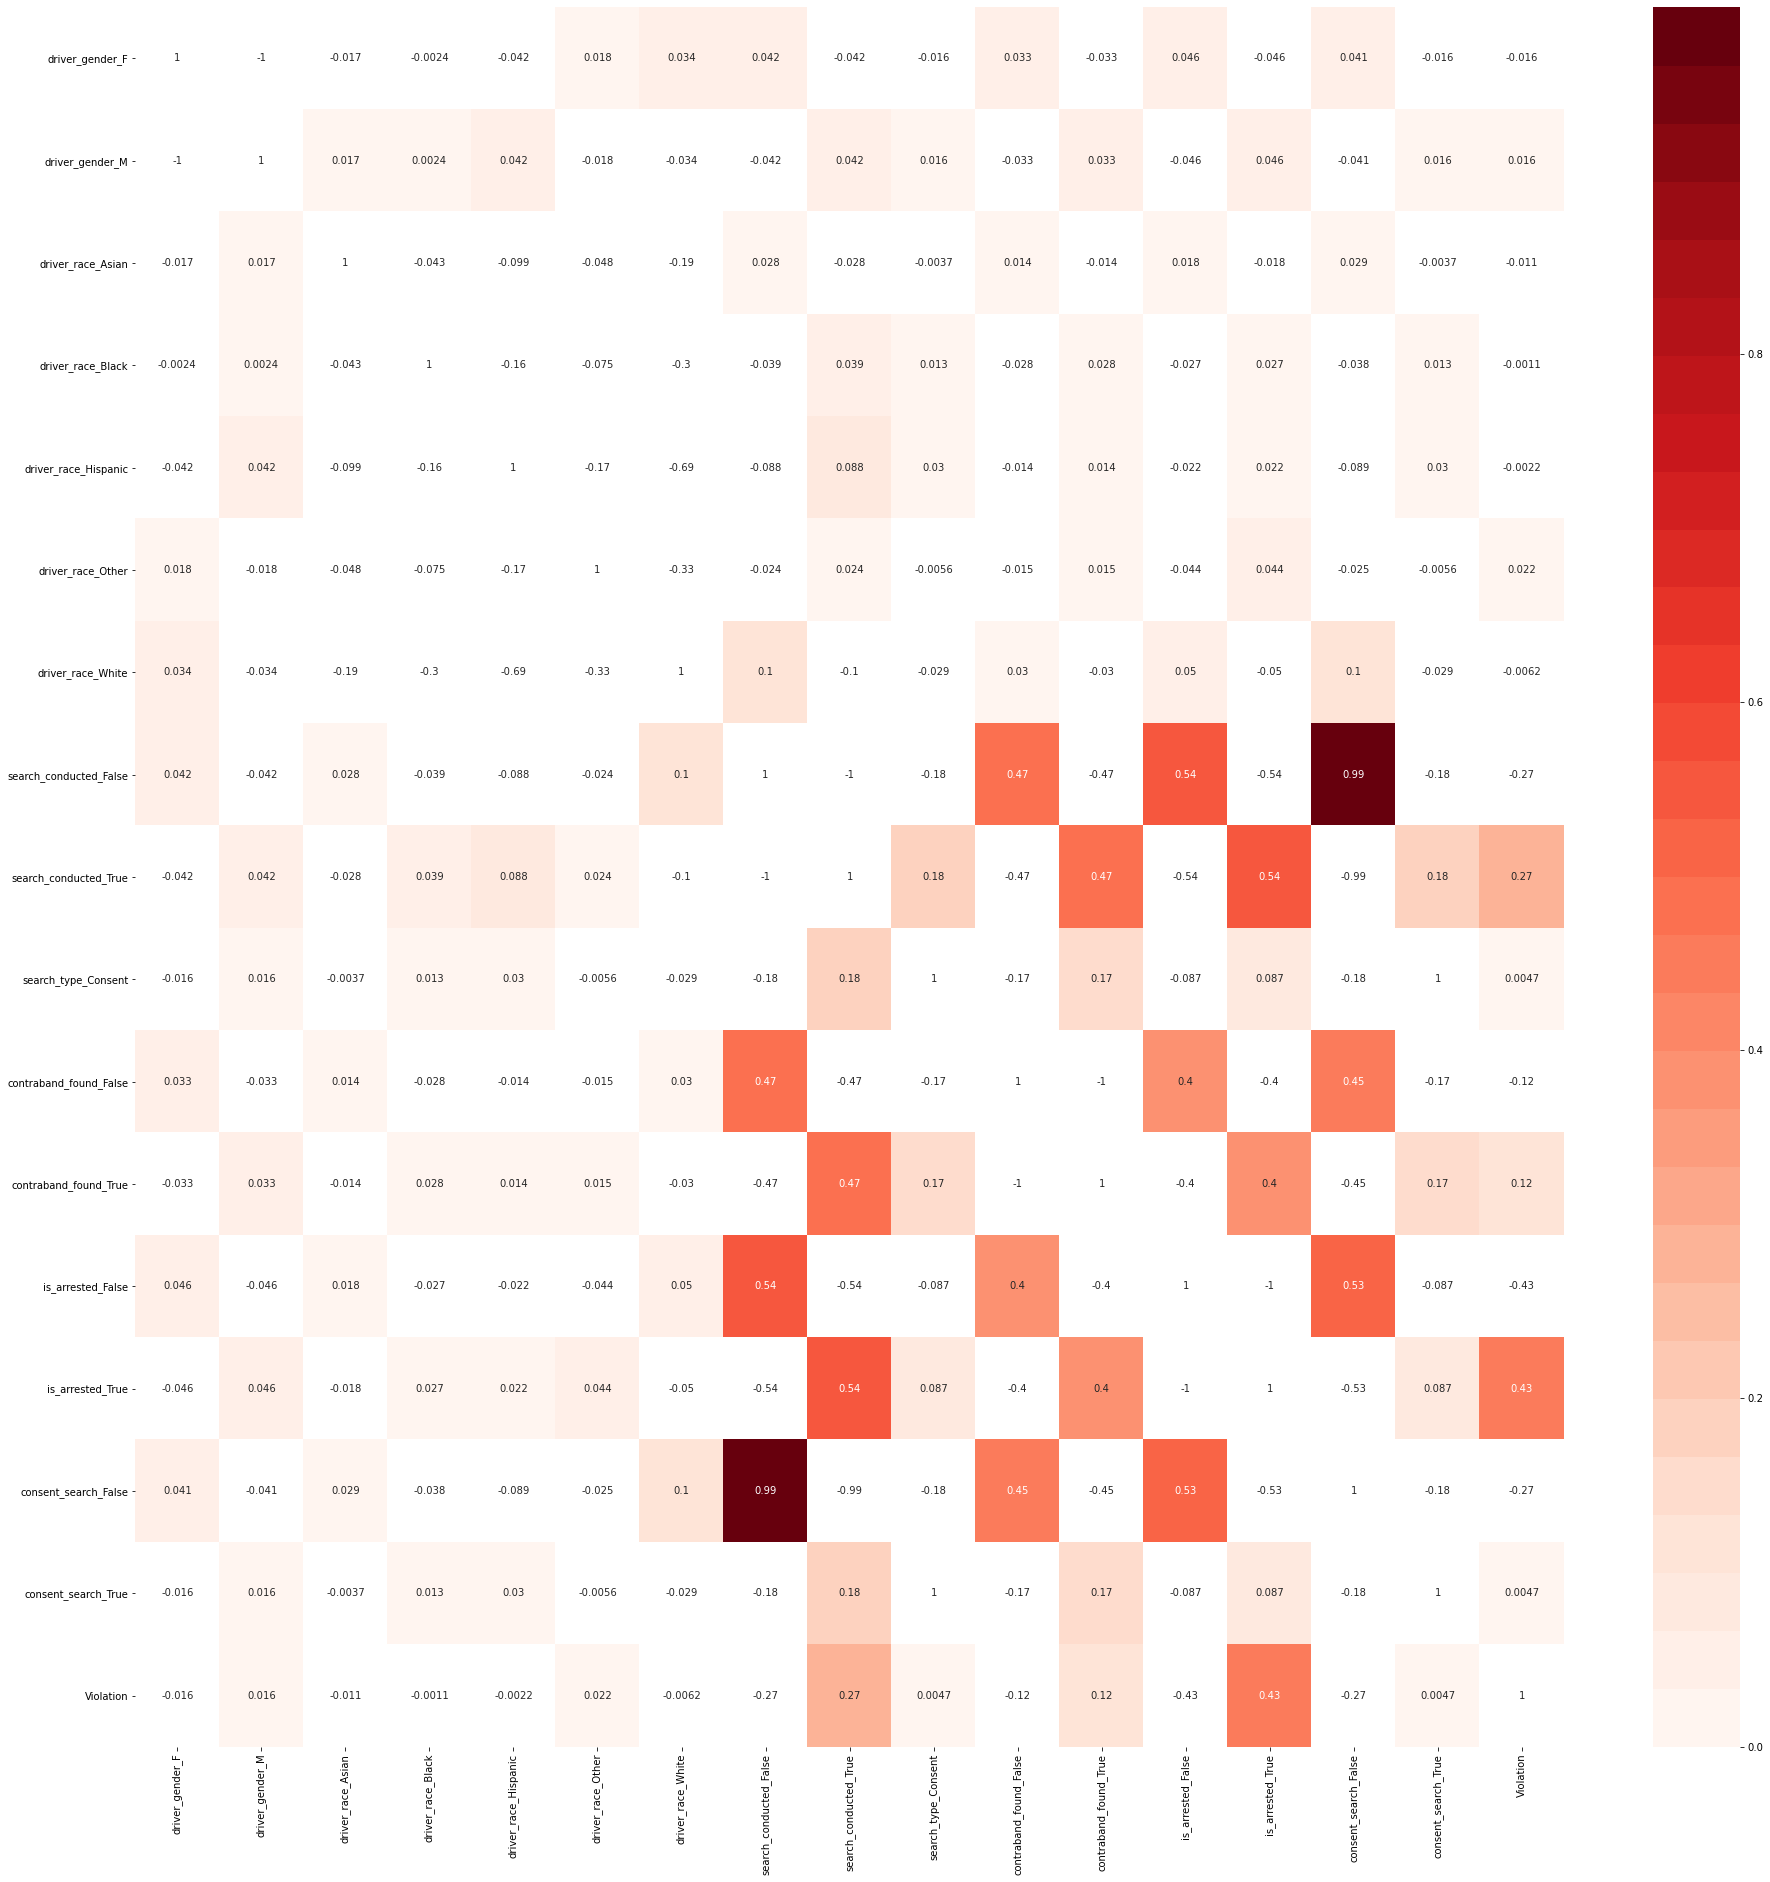

In [156]:
import seaborn as sns
plt.figure(figsize=(32, 32))
cmap = plt.get_cmap('Reds',30)
cmap.set_under('white')
cmap.set_over('white')
heatmap = sns.heatmap(Xd.corr(), vmin=0, vmax=0.999, annot=True, cmap=cmap)
#heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


    HYPERPARAMETER TUNING (TESTING ALL COMBINATIONS OF DIFFERENT PARAMETER VALUES, TO SEE WHAT GIVES THE BEST TRAIN AND TEST RESULTS)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
%matplotlib inline  

rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
gbm_model = GradientBoostingClassifier()

def rforest_tuning():
    Trees = [1, 10, 25, 50, 100, 150] #number of trees considered in random forest
    maxFeatures = [1, 5, 10, 15] #number of features considered at each split
    maxDepth = [1, 5, 10, 25, 50, 100] #max number of levels in a tree
    minSamplesSplit = [1.0, 2, 3, 4] #minimum number of samples for a node to split
    minSamplesLeaf = [1, 2, 3] #minimum number of samples required at each leaf node

    parameter_grid = {'n_estimators' : Trees,
                    'max_features' : maxFeatures,
                    'max_depth' : maxDepth,
                    'min_samples_split' : minSamplesSplit,
                    'min_samples_leaf' : minSamplesLeaf}
    
    rf_grid = GridSearchCV(estimator = rf_model, param_grid = parameter_grid, cv = 3, verbose = 2, n_jobs = 4) 
    rf_grid.fit(X_train, y_train)

    print(rf_grid.best_params_)
    print (f'Train Accuracy : {rf_grid.score(X_train,y_train):.3f}')
    print (f'Test Accuracy : {rf_grid.score(X_test,y_test):.3f}')

    """ # identifying and plotting feature importance
    importance = rf_model.feature_importances_
    for i,j in enumerate(importance):
        print(f'Feature: {i}, Score: {j}%.5f')

    plt.bar([x for x in range(len(importance))], importance)
    plt.show() """


def knn_tuning():
    parameter_grid = {'n_neighbors' : [1, 3, 5, 7, 9, 11, 13, 15],
                      'weights' : ['uniform', 'distance'],
                      'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
    knn_grid = GridSearchCV(estimator = knn_model, param_grid = parameter_grid, cv = 3, verbose = 2, n_jobs = -1)
    knn_grid.fit(X_train, y_train)

    print(knn_grid.best_params_)
    print (f'Train Accuracy : {knn_grid.score(X_train,y_train):.3f}')
    print (f'Test Accuracy : {knn_grid.score(X_test,y_test):.3f}')


def GBM_tuning():
    parameter_grid = {'min_samples_split': range(200, 1001, 200),
                      'min_samples_leaf' : range(30, 71, 10),
                      'max_depth' : range(5, 16, 2),
                      'max_features' : ['sqrt'],
                      'subsample' : [0.8]}
    GBM_grid = GridSearchCV(estimator = gbm_model, param_grid = parameter_grid, cv = 3, verbose = 2, n_jobs = 4)
    GBM_grid.fit(X_train, y_train)

    print(GBM_grid.best_params_)
    print (f'Train Accuracy : {GBM_grid.score(X_train,y_train):.3f}')
    print (f'Test Accuracy : {GBM_grid.score(X_test,y_test):.3f}')

In [ ]:
rforest_tuning()

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


KeyboardInterrupt: 

In [ ]:
GBM_tuning()

In [ ]:
knn_tuning()

In [ ]:
def feat_importance(model):
    Xd_train, Xd_test, y_train, y_test = train_test_split(Xd, y, random_state = 0)

    model.fit(Xd_train, y_train)
    importance = model.feature_importances_
    for i,j in enumerate(importance):
        print(f'Feature: {i}, Score: {j:.5f}')

    feat_importances = pd.Series(model.feature_importances_, index = Xd.columns)
    feat_importances.nlargest(15).plot(kind = 'barh').invert_yaxis()

feat_importance(rf_model)

violation_Speeding                         0.367113
violation_Moving violation                 0.073771
violation_Other                            0.064291
violation_Paperwork                        0.045297
is_arrested_True                           0.042679
violation_Registration/plates              0.039019
is_arrested_False                          0.033978
violation_Paperwork,Speeding               0.029460
violation_Safe movement                    0.026039
violation_License                          0.022011
violation_Equipment                        0.017284
violation_Paperwork,Registration/plates    0.016535
violation_Other,Speeding                   0.013566
violation_Other,Paperwork                  0.012798
violation_License,Speeding                 0.012024
search_conducted_False                     0.011909
violation_Stop sign/light                  0.011167
consent_search_False                       0.011007
violation_Moving violation,Paperwork       0.008150
search_condu

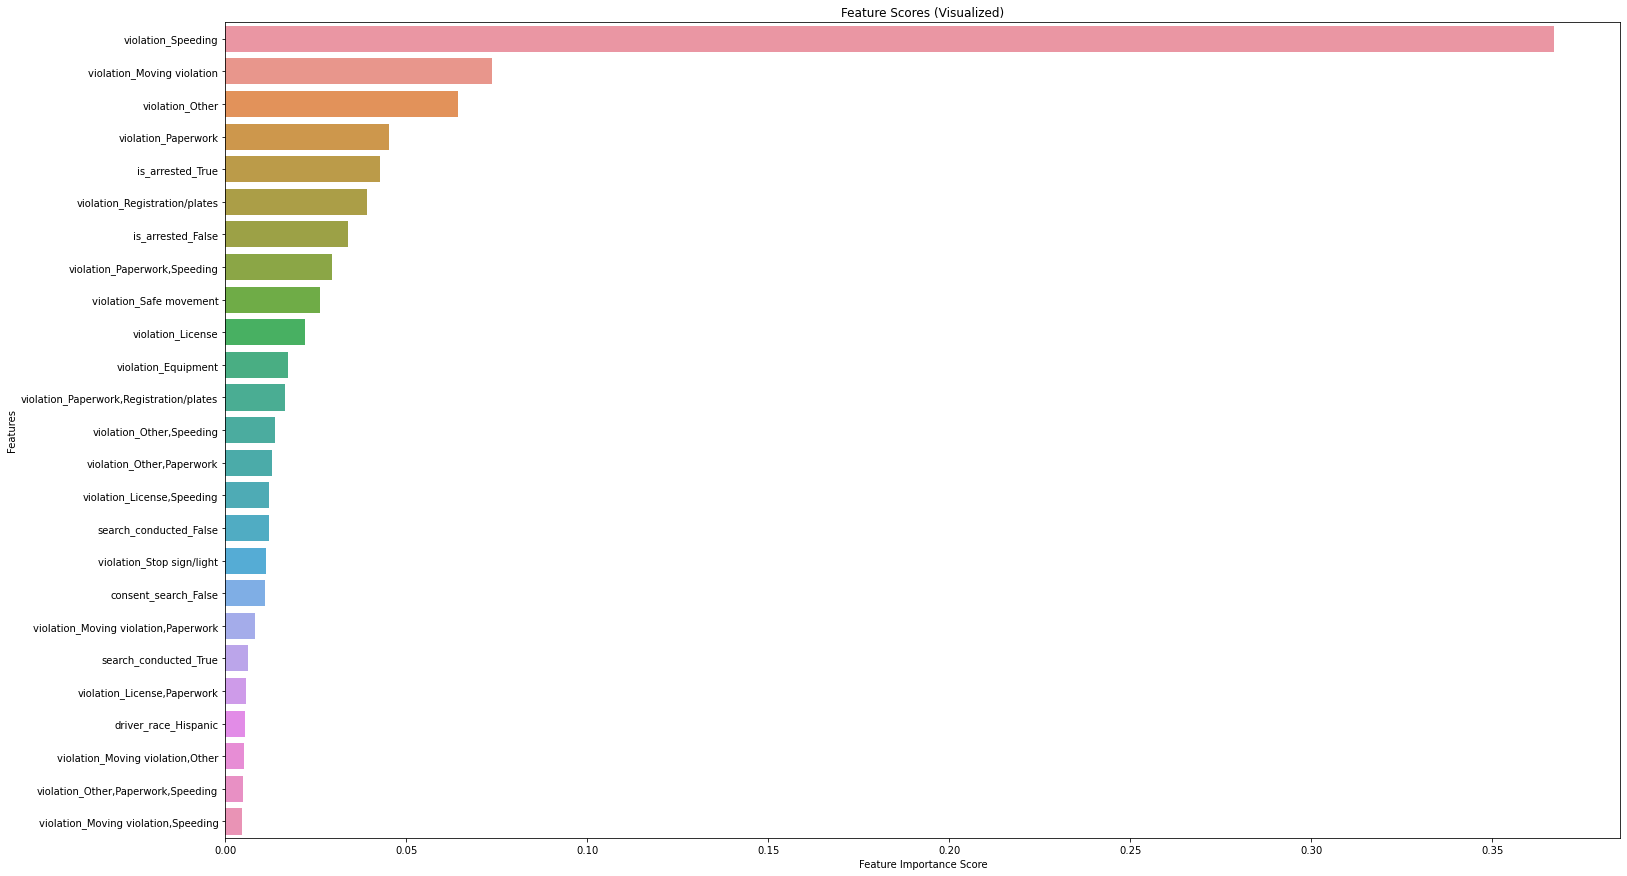

In [ ]:
def feature_importances():
    Xd_train, Xd_test, y_train, y_test = train_test_split(Xd, y, random_state = 0)
    rfc_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
    rfc_model.fit(Xd, y)
    feature_scores = pd.Series(rfc_model.feature_importances_, index = Xd_train.columns).sort_values(ascending = False).nlargest(25) #nlargest can be removed to plot all features
    print(feature_scores)

    def visualize_importance():
        f, ax = plt.subplots(figsize = (25,15))
        ax = sns.barplot(x = feature_scores, y = feature_scores.index, data = df_testing)
        ax.set_title('Feature Scores (Visualized)')
        ax.set_yticklabels(feature_scores.index)
        ax.set_xlabel('Feature Importance Score')
        ax.set_ylabel('Features')

        plt.show

    visualize_importance()

feature_importances()


In [ ]:
#rf_grid = GridSearchCV(estimator = rf_model, param_grid = parameter_grid, cv = 3, verbose = 2, n_jobs = 4) 
#rf_grid.fit(X_train, y_train) #the 'cv' value is the class validation score, by increasing it, it evalues the model n amount of times, can
                              #improve accuracy, however it does make it take longer to run. With a cv of 10, the accuracy of test is 0.851.

In [ ]:
#rf_grid.best_params_

In [ ]:
print(rf_grid.best_params_)
print (f'Train Accuracy : {rf_grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy : {rf_grid.score(X_test,y_test):.3f}')

                                THE CODE BELOW IS THE FIRST VERSIONS OF BOTH THE PARAMETER OPTIMIZATION AND FEATURE IMPORTANCE GRAPHICS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state = 0)

rforest = RandomForestClassifier(max_depth = 50, random_state = 0) #possible parameters :max_depth, min_sample_split, max_leaf_nodes
                                                            #min_samples_leaf, n_estimators, max_sample (bootstrap sample), max_features

rforest.fit(X_train, y_train)
train_score = rforest.score(X_train, y_train)
test_score = rforest.score(X_test, y_test)

print('Train   Test')
print('{:.3f} {:7.3f}'.format(train_score, test_score)) #unsure if these results are correct, is there a way to make it faster?

In [ ]:
import matplotlib.pyplot as plt

def specific_parameters():
        user_inputs = []
        parameters = ['max_depth', 'min_sample_split', 'max_leaf_nodes', 'min_samples_leaf', 'n_estimators', 'max_sample', 'max_features']
        for item in parameters:
            user_input = input(f'Please select a value for the parameter {item}:')
            if user_input.type() != 'float':
                user_inputs.append('None')
            else:
                user_inputs.append(user_input)
        return user_inputs

def test_parameter():
    number = [1, 5, 10, 25, 50, 100]
    print('Parameter size   Train   Test')
    results_train = []
    results_test = []
    for i in number:
        model = KNeighborsClassifier(n_neighbors = i, algorithm = 'auto', weights = 'distance')#max_features = 10, min_samples_leaf = 1, min_samples_split= 3, n_estimators= 150, random_state = 0)
        model.fit(X_train, y_train)

        #TRAIN
        train_score = model.score(X_train, y_train)
        results_train.append(train_score)
        
        #TEST
        test_score = model.score(X_test, y_test)
        results_test.append(test_score)

        print('{:8d} {:13.3f} {:7.3f}'.format(i, train_score, test_score))

    x = number
    y = results_train
    plt.plot(x,y)
    y = results_test 
    plt.plot(x,y)

#test_parameter() #note --> random grid can be used to optimize finding the best feature values

In [ ]:
def modelfit(algorithm, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #fit the data to the algorithm
    algorithm.fit(dtrain[predictors], dtrain['Disbursed'])
    
    #predict training set
    dtrain_predictions = algorithm.predict(dtrain[predictors])
    dtrain_probabilities = algorithm.predict_proba(dtrain[predictors])[:,1]

    #perform cross validation
    if performCV:
        cv_score = model_selection.cross_val_score(algorithm, dtrain[predictors], dtrain['Disbursed'], cv = cv_folds, scoring = 'roc_auc')
    
    #model results
    print('\nModel Results')
    print('Accuracy : %4g' %metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print('AUC score (train): %f' %metrics.roc_auc_score(dtrain['Disbursed'], dtrain_probabilities))

    if performCV:
        print('CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g' % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
    
    #feature importance
    if printFeatureImportance:
        feat_imp = pd.Series(algorithm.feature_importances_, predictors).sort_values(ascending = False)
        feat_imp.plot(kind = 'bar', title = 'Feature Importances')
        plt.ylabel('Feature Importance Score')
        
